# CNN study case: train on Cifar10.

On this notebook we will cover the training of a simple model on the CIFAR 10 dataset, and we will cover the next topics:
- Cifar10 dataset
- Model architecture: 
    - 2D Convolutional layers
    - MaxPooling
    - Relu activation
    - Batch normalization
- Image generator data augmentation
- TTA (Test time augmentation)
### The dataset

The dataset is composed by 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. These are the image classes:
- airplane 
- automobile 
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

In [1]:
import os


import tensorflow as tf

tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.utils import to_categorical

(trainX, trainY), (testX, testY) = load_data()
# normalize pixel values
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainX[0].shape

(32, 32, 3)

In [9]:
trainX[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

<font color=red><b>Plot some examples of the dataset.
<br>Hint: use the imshow function of the pyplot package</b>
</font>

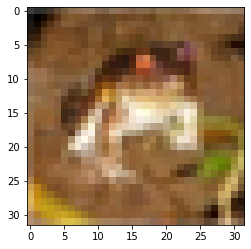

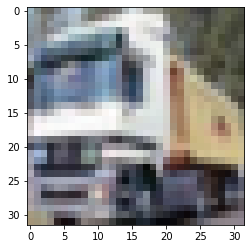

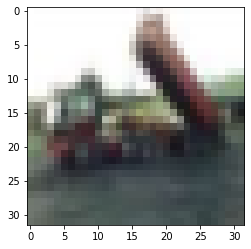

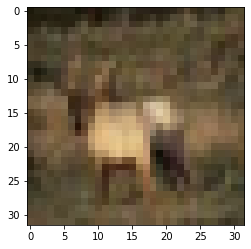

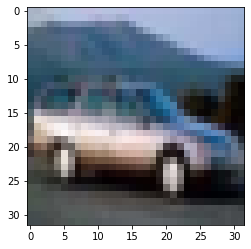

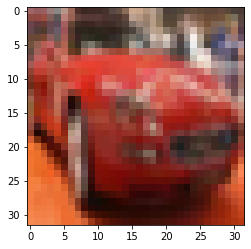

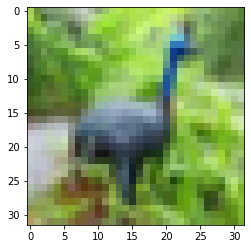

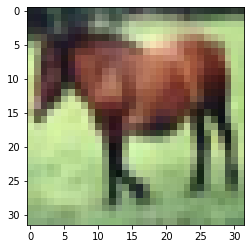

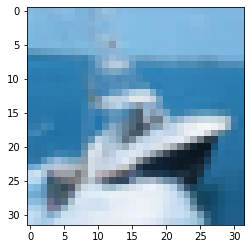

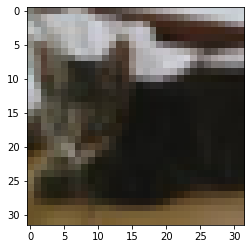

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

for j in range (10):
    plt.imshow((trainX[j]*255).astype('uint8'))
    plt.show()
    


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from numpy import mean
from numpy import std

## Model Architecture
Build the CNN model to be trained train on the data, on this config:
- Conv2d layer, with 32 units and 3x3 filter, with relu activation and padding of "same" type. Use the "he_uniform" initializer.
- batchnorm
- max pooling (2x2)
- Conv2d layer, with 64 units and 3x3 filter, with relu activation and padding of "same" type. Use the "he_uniform" initializer.
- batchnorm
- max pooling (2x2)
- Dense layer, with 128 units
- Dense softmax layer
- On compilation, use adam as the optimizer and categorical_crossentropy as the loss function. Add 'accuracy' as a metric
- Print the summary


<font color=red><b>Remember to initialize it propperly and to include input_shape on the first layer. <br> Hint: 
- Use the imported libraries</b></font>

In [12]:
?Conv2D

In [13]:
def define_model():
    # define model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', 
                     kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

We are going to train small steps of our model in order to evaluate the hyperparameters and the strategy. In order to do that, we will define a step epochs number and will train and evaluate the model for that amount of epochs. after a number of repeats we will reduce the effect random initialization of certain parameters.

<font color=red>Evaluate the built model by training 10 times on different initializations<b> Hint: we would like to have some parameters of the score distribution, like the ones imported  </b></font>

In [14]:
step_epochs = 3
batch_size = 128

def evaluate_model(model, trainX, trainY, testX, testY):
    # fit model
    model.fit(trainX, trainY, epochs=step_epochs, batch_size=batch_size, verbose=0)
    # evaluate model
    loss, acc = model.evaluate(testX, testY, verbose=0)
    return acc


def evaluate(trainX, trainY, testX, testY, repeats=5):
    scores = list()
    for _ in range(repeats):
        # define model
        model = define_model()
        # fit and evaluate model
        accuracy = evaluate_model(model, trainX, trainY, testX, testY)
        # store score
        scores.append(accuracy)
        print('> %.3f' % accuracy)
    return scores


# evaluate model
scores = evaluate(trainX, trainY, testX, testY)
# summarize result
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

> 0.692
> 0.646
> 0.664
> 0.670
> 0.678
Accuracy: 0.670 (0.015)


### Keras Image data generator
In order to perform some data augmentation, Keras includes the Image data generator, which can be used to improve performance and reduce generalization error when training neural network models for computer vision problems. 
A range of techniques are supported, as well as pixel scaling methods. Some of the most commn are: 

- Image shifts via the width_shift_range and height_shift_range arguments.
- Image flips via the horizontal_flip and vertical_flip arguments.
- Image rotations via the rotation_range argument
- Image brightness via the brightness_range argument.
- Image zoom via the zoom_range argument.


Let's see it with an example:


In [7]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
samples.shape

(1, 32, 32, 3)

/home/fer/data/venvs/dl_tf2/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/fer/data/venvs/dl_tf2/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


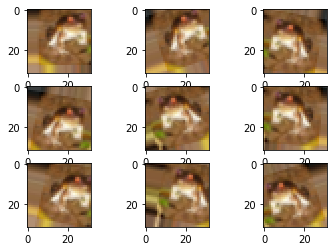

In [16]:
# expand dimension to one sample
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data = trainX[0]*255
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True, 
                             featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

In [17]:
batch.shape

(1, 32, 32, 3)

<font color=red>Evaluate the model with data augmentation <br> Hint: Use the ?model.fit_generator command and please take into acount the parameters of the model.fit_generator: It needs to include: epochs, steps_per_epoch and a generator (i.e: a flow of images). </font>

In [18]:
# fit and evaluate a defined model
def evaluate_model_increased(model, trainX, trainY, testX, testY):
    datagen = ImageDataGenerator(horizontal_flip=True)
    # in case there is mean/std to normalize
    datagen.fit(trainX)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(trainX, trainY,
                                     batch_size=batch_size),
                        epochs=step_epochs,
                        steps_per_epoch=len(trainX) // batch_size,
                        verbose = 0)
    
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    return acc

# repeatedly evaluate model, return distribution of scores
def repeated_evaluation_increased(trainX, trainY, testX, testY, repeats=5):
    scores = list()
    for _ in range(repeats):
        # define model
        model = define_model()
        # fit and evaluate model
        accuracy = evaluate_model_increased(model, trainX, trainY, testX, testY)
        # store score
        scores.append(accuracy)
        print('> %.3f' % accuracy)
    return scores

# evaluate model
scores = repeated_evaluation_increased(trainX, trainY, testX, testY)
# summarize result
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

> 0.644
> 0.695
> 0.660
> 0.683
> 0.681
Accuracy: 0.673 (0.018)


### Test Time augmentation (TTA)

The image data augmentation technique can also be applied when making predictions with a fit model in order to allow the model to make predictions for multiple different versions of each image in the test dataset. Specifically, it involves creating multiple augmented copies of each image in the test set, having the model make a prediction for each, then returning an ensemble of those predictions.(e.g: majority voting in case of classification)

Augmentations are chosen to give the model the best opportunity for correctly classifying a given image, and the number of copies of an image for which a model must make a prediction is often small, such as less than 10 or 20. Often, a single simple test-time augmentation is performed, such as a shift, crop, or image flip.

<font color=red>Evaluate the model with data augmentation. <b>Please note on this case we are not going to use the generateor on training, but on testing.</b> <br> Hint: Use the model.predict_generator function </font>

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
n_examples_per_image = 2


# make a prediction using test-time augmentation
def prediction_augmented_on_test(datagen, model, image, n_examples):
    # convert image into dataset
    samples = expand_dims(image, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=n_examples)
    # make predictions for each augmented image
    yhats = model.predict_generator(it, steps=n_examples, verbose=0)
    # sum across predictions
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    return np.argmax(summed)

# evaluate a model on a dataset using test-time augmentation
def evaluate_model_test_time_agumented(model, testX, testY):
    # configure image data augmentation
    datagen = ImageDataGenerator(horizontal_flip=True)
    # define the number of augmented images to generate per test set image
    yhats = list()
    for i in range(len(testX)):
        # make augmented prediction
        yhat = prediction_augmented_on_test(datagen, model, testX[i], n_examples_per_image)
        # store for evaluation
        yhats.append(yhat)
    # calculate accuracy
    testY_labels = np.argmax(testY, axis=1)
    acc = accuracy_score(testY_labels, yhats)
    return acc

def evaluate_model_test_augmented(model, trainX, trainY, testX, testY):
    # fit model
    model.fit(trainX, trainY, epochs=step_epochs, batch_size=batch_size, verbose=0)
    # evaluate model
    acc = evaluate_model_test_time_agumented(model, testX, testY)
    return acc

def evaluate_test_augmented(trainX, trainY, testX, testY, repeats=10):
    scores = list()
    for _ in range(repeats):
        # define model
        model = define_model()
        # fit and evaluate model
        accuracy = evaluate_model_test_augmented(model, trainX, trainY, testX, testY)
        # store score
        scores.append(accuracy)
        print('> %.3f' % accuracy)
    return scores


# evaluate model
scores = evaluate_test_augmented(trainX, trainY, testX, testY)
# summarize result
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))